### Here i run my custom made SymmetricNet Updated from previous models such that it doesnt take flip vertical adjustments into first pooling layer but displacement in vertical axis instead, no data agumentation are itroduced here 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary

import sys
from pathlib import Path

#torch 
import torch
import torchvision as torchv
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch import Tensor
from torch.utils import data
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

import pandas as pd
import seaborn as sn

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


In [3]:
module_path = str(Path.cwd().parents[0].parents[0] / "methods")

if module_path not in sys.path:
    sys.path.append(module_path)

from dataloader import *
# from plotCreator import *

data_path0 = str(Path.cwd().parents[0].parents[0] / "data" / "BH_n4_M10_res50_15000_events.h5")
data_path1 = str(Path.cwd().parents[0].parents[0] / "data" / "PP13-Sphaleron-THR9-FRZ15-NB0-NSUBPALL_res50_15000_events.h5")

In [4]:
bhArray = dataToArray(data_path0)
sphArray = dataToArray(data_path1)

In [5]:
#Kombinerer dataene for å kunne kjøre gjennom modellen på et samlet datasett
dataArray = np.concatenate((bhArray,sphArray),axis=0)

In [6]:
# Labeler tabelle med 1 og 0 (0 = svart hull, 1 = spahleron)
labelsArray = np.concatenate((np.zeros(np.shape(bhArray)[0]),np.ones(np.shape(sphArray)[0])),axis=0)

In [7]:
#Split data 75% i train og 25% i test
trainData, testData, trainLabels, testLabels = train_test_split(dataArray, labelsArray, random_state=42)

In [8]:
trainData = torch.from_numpy(trainData).permute(0,3,1,2)
testData = torch.from_numpy(testData).permute(0,3,1,2)
trainLabels = torch.from_numpy(trainLabels)
testLabels = torch.from_numpy(testLabels)

In [9]:
#Transformere numpy til tensor
train = torch.utils.data.TensorDataset(trainData, trainLabels)
test = torch.utils.data.TensorDataset(testData, testLabels)

In [10]:
#Sette data til å vere dataloaders
trainLoader = DataLoader(train, shuffle=True, batch_size=50)
testLoader = DataLoader(test, shuffle=True, batch_size=50)

In [11]:
from torchsummary import summary
import nnmodel

#Her måp det endres sidan den aksepterer ikek parametere gitt
model = nnmodel.ConvModel(0.5).to(device)
summary(model, (3, 50, 50))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 50, 50]           1,792
       BatchNorm2d-2           [-1, 64, 50, 50]             128
            Conv2d-3          [-1, 128, 25, 25]          73,856
       BatchNorm2d-4          [-1, 128, 25, 25]             256
            Conv2d-5          [-1, 256, 12, 12]         295,168
       BatchNorm2d-6          [-1, 256, 12, 12]             512
            Conv2d-7            [-1, 512, 6, 6]       1,180,160
       BatchNorm2d-8            [-1, 512, 6, 6]           1,024
            Conv2d-9           [-1, 1024, 3, 3]       4,719,616
      BatchNorm2d-10           [-1, 1024, 3, 3]           2,048
           Linear-11                 [-1, 2048]       2,099,200
          Dropout-12                 [-1, 2048]               0
           Linear-13                  [-1, 512]       1,049,088
          Dropout-14                  [

Trene modellen vår her, muligens implementere wandb her for å deploye modellen og se progressjonen og sammenligne med andre modeller samnt data agumentering kan komme med i denne delen av koden?

Epoch: 0/50
Train Loss: 0.3912, Train Accuracy: 79.13%
Test Loss: 0.2504, Test Accuracy: 90.77%
Epoch: 1/50
Train Loss: 0.3429, Train Accuracy: 81.28%
Test Loss: 0.1853, Test Accuracy: 92.85%
Epoch: 2/50
Train Loss: 0.3386, Train Accuracy: 81.64%
Test Loss: 0.4274, Test Accuracy: 82.48%
Epoch: 3/50
Train Loss: 0.3224, Train Accuracy: 82.42%
Test Loss: 0.4482, Test Accuracy: 84.44%
Epoch: 4/50
Train Loss: 0.3210, Train Accuracy: 82.20%
Test Loss: 0.1922, Test Accuracy: 92.99%
Epoch: 5/50
Train Loss: 0.3084, Train Accuracy: 82.59%
Test Loss: 0.2381, Test Accuracy: 90.97%
Epoch 00006: reducing learning rate of group 0 to 5.0000e-04.
Epoch: 6/50
Train Loss: 0.2992, Train Accuracy: 82.88%
Test Loss: 0.1667, Test Accuracy: 93.91%
Epoch: 7/50
Train Loss: 0.2949, Train Accuracy: 83.18%
Test Loss: 0.1635, Test Accuracy: 94.09%
Epoch: 8/50
Train Loss: 0.2926, Train Accuracy: 82.68%
Test Loss: 0.1807, Test Accuracy: 93.48%
Epoch: 9/50
Train Loss: 0.2922, Train Accuracy: 82.97%
Test Loss: 0.1696, 

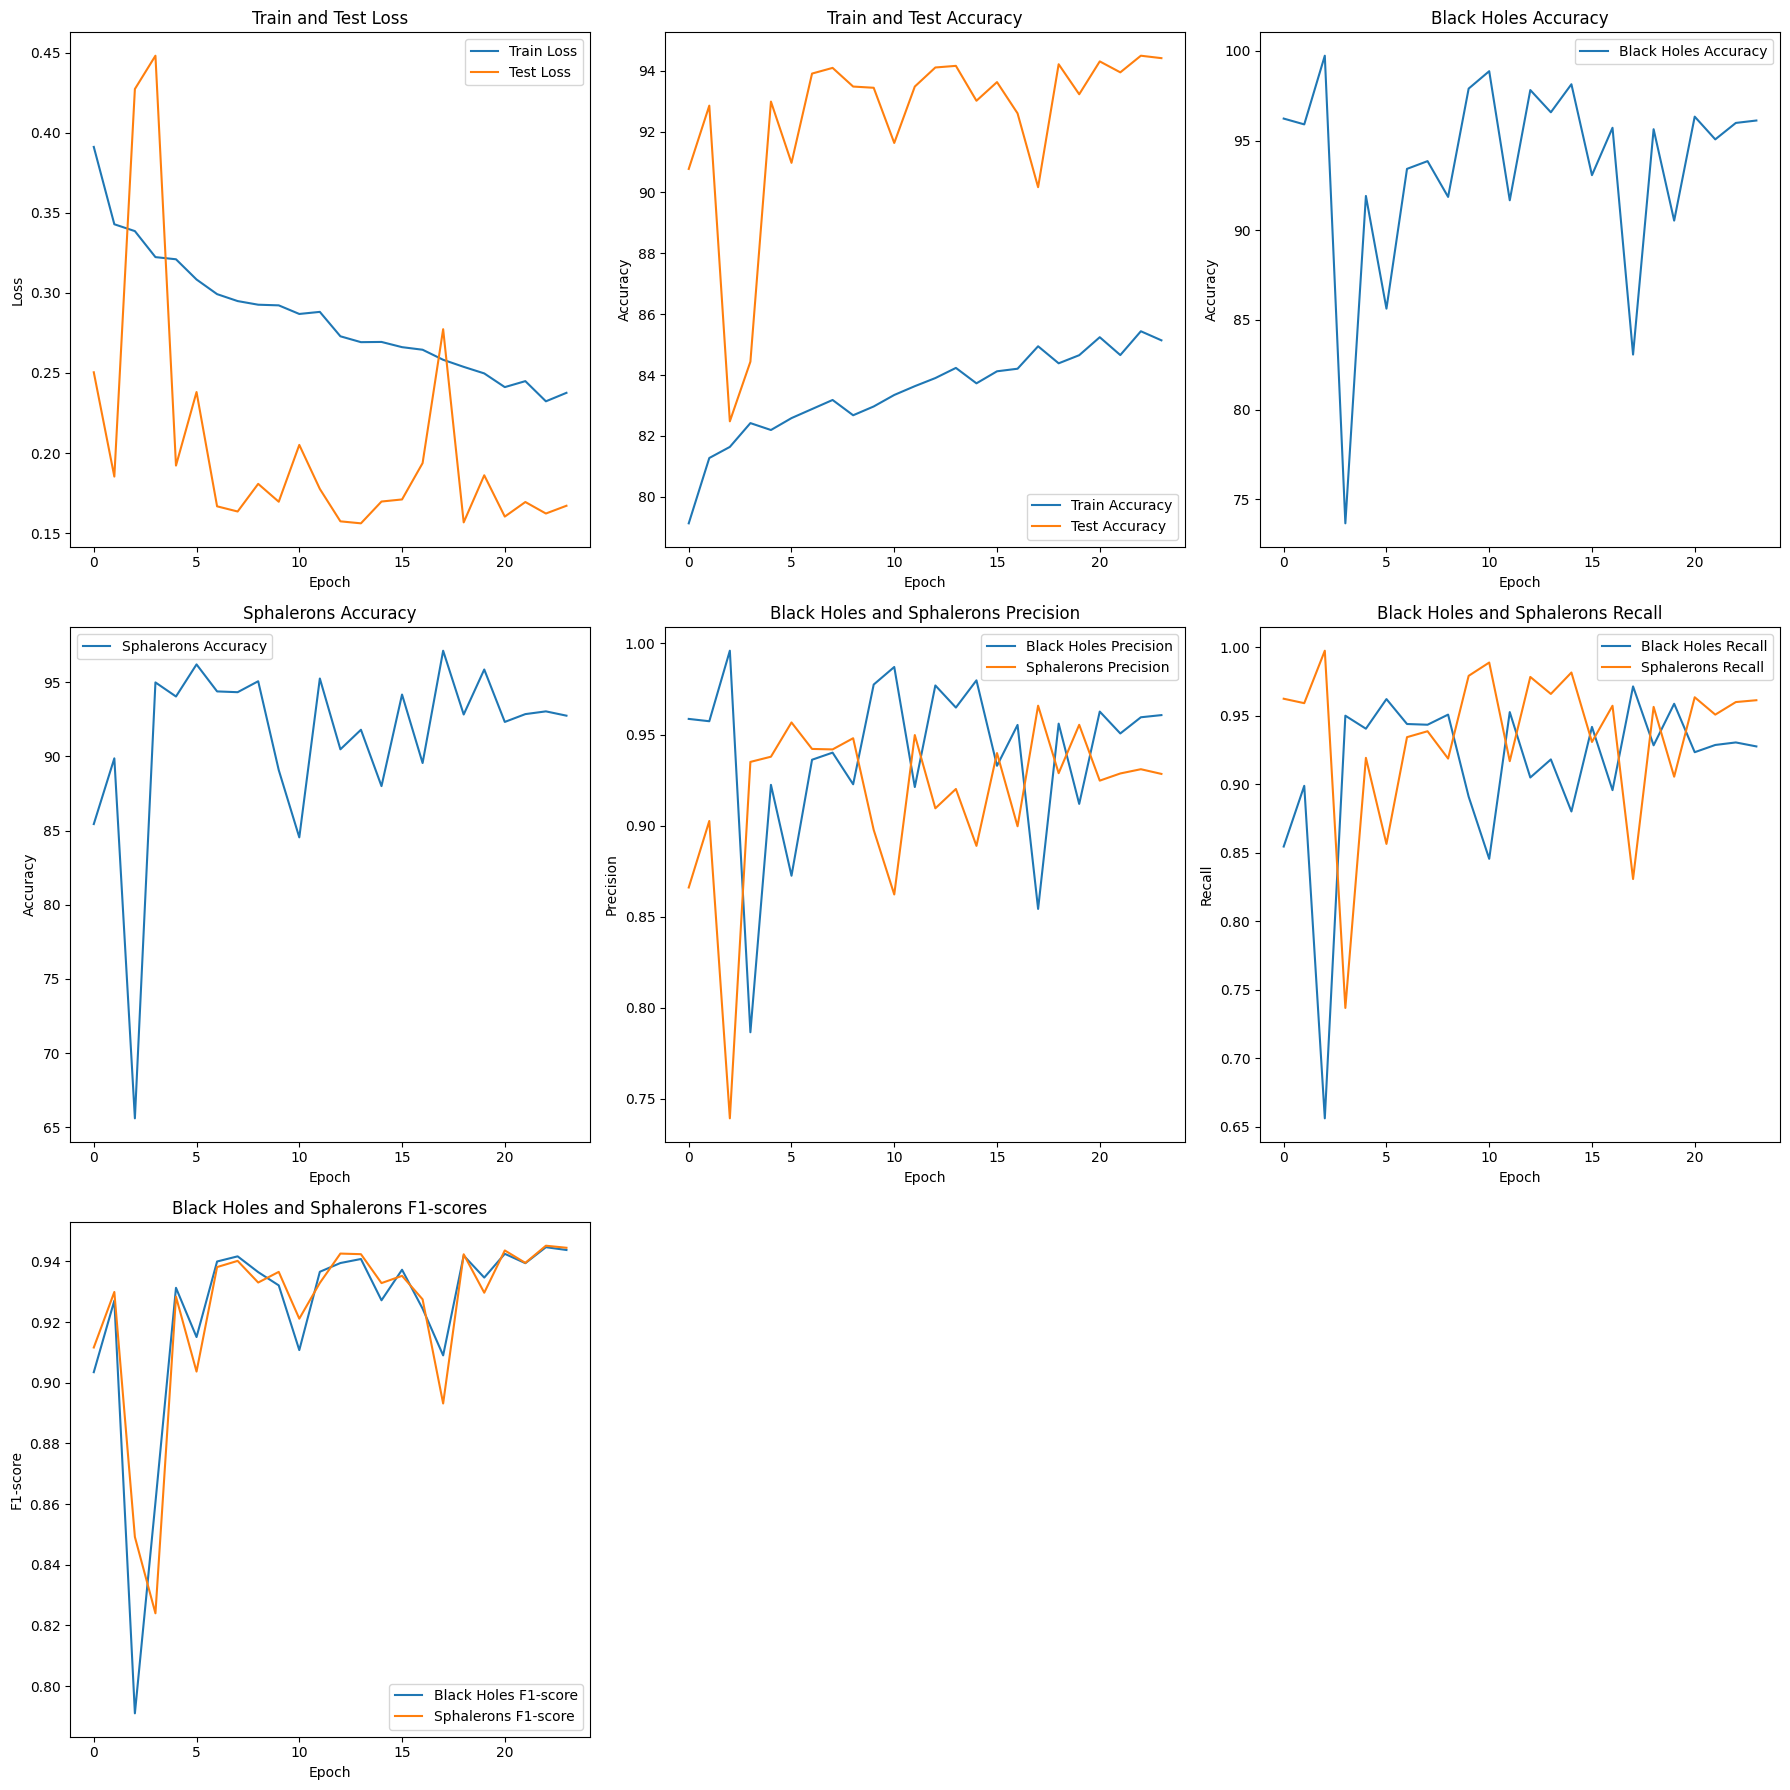

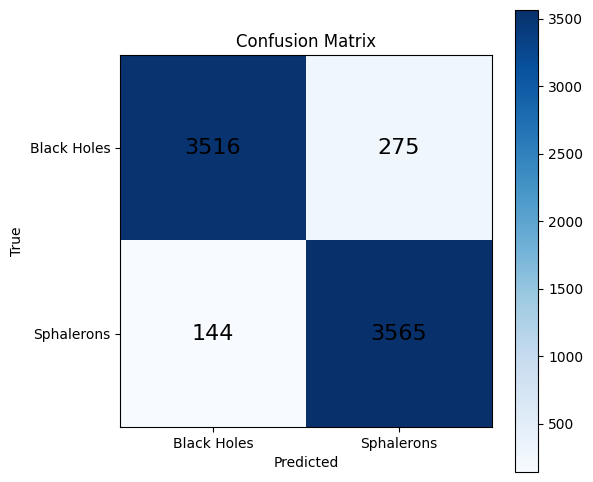

In [18]:
import trainer

n_epochs = 50

model = nnmodel.ConvModel(0.5).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters())
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True, factor=0.5)

trainer.train(model, trainLoader, testLoader, optimizer, criterion, n_epochs, scheduler = scheduler, early_stopping_patience=10)